In [4]:
import pandas as pd
import os

def parse_log_file(file_content):
    lines = file_content.strip().split('\n')
    data = []

    for line in lines:
        if '|' not in line or 'Timestamp' in line or '----' in line or any(skip in line for skip in ['Rec', 'Final', 'Consecutive', 'Total', 'Average', 'Turn']):
            continue

        parts = [part.strip() for part in line.split('|')]
        if len(parts) >= 12:
            try:
                timestamp = parts[0]
                packet_num = int(parts[1]) if parts[1].strip().isdigit() else None
                received = 1 if parts[2].strip() == 'Yes' else 0
                prr = float(parts[3].strip().replace('%', '')) if parts[3].strip() != '' else None
                delta_time = int(parts[4].strip().split()[0]) if parts[4].strip() not in ['N/A', ''] else None
                rssi = int(parts[7]) if parts[7].strip() not in ['N/A', ''] else None
                adjustment = int(parts[9]) if parts[9].strip() not in ['N/A', ''] else None
                new_sleep_time = int(parts[10]) if parts[10].strip() not in ['N/A', ''] else None

                data.append({
                    'timestamp': timestamp,
                    'packet_num': packet_num,
                    'received': received,
                    'prr': prr,
                    'delta_time': delta_time,
                    'rssi': rssi,
                    'adjustment': adjustment,
                    'new_sleep_time': new_sleep_time
                })
            except:
                continue

    return pd.DataFrame(data)


def read_all_logs(base_dir):
    all_logs = {}
    for exp_name in sorted(os.listdir(base_dir)):
        if not exp_name.startswith("exp"): continue
        exp_path = os.path.join(base_dir, exp_name)
        all_logs[exp_name] = {}
        for dev_file in sorted(os.listdir(exp_path)):
            if not dev_file.startswith("dev") or "dev 9" in dev_file: continue
            dev_path = os.path.join(exp_path, dev_file)
            with open(dev_path, 'r', encoding='utf-8') as f:
                file_content = f.read()
                df = parse_log_file(file_content)
                all_logs[exp_name][dev_file] = df
    return all_logs


def prepare_features(df):
    df = df.copy().dropna(subset=['new_sleep_time'])
    df['prev_delta'] = df['delta_time'].shift(1)
    df['prev_rssi'] = df['rssi'].shift(1)
    df['prev_received'] = df['received'].shift(1)
    df['prev_sleep_time'] = df['new_sleep_time'].shift(1)
    df['delta_change'] = df['delta_time'] - df['prev_delta']
    df['rssi_change'] = df['rssi'] - df['prev_rssi']
    df['rolling_delta_avg'] = df['delta_time'].rolling(window=3, min_periods=1).mean()
    df['rolling_rssi_avg'] = df['rssi'].rolling(window=3, min_periods=1).mean()
    df = df.dropna()

    selected_features = ['delta_time', 'rssi', 'prev_delta',
                         'prev_rssi', 'prev_received', 'prev_sleep_time',
                         'delta_change', 'rssi_change', 'rolling_delta_avg',
                         'rolling_rssi_avg']

    X = df[selected_features]
    y = df['new_sleep_time']

    return X, y, df

def aggregate_data(logs, include_devices):
    X_all, y_all = [], []

    for exp_name, devices in logs.items():
        for dev_name, df in devices.items():
            if dev_name not in include_devices:
                continue
            try:
                X, y, _ = prepare_features(df)
                X_all.append(X)
                y_all.append(y)
            except Exception as e:
                print(f"Error with {exp_name} / {dev_name}: {e}")

    # Concatenate all
    X_all = pd.concat(X_all, axis=0)
    y_all = pd.concat(y_all, axis=0)
    return X_all, y_all

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

def train_and_evaluate_linear(X_train, y_train, X_test, y_test):
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    y_pred_lr = lin_model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred_lr)
    mae = mean_absolute_error(y_test, y_pred_lr)
    r2 = r2_score(y_test, y_pred_lr)
    print(f"Linear Regression → RMSE: {np.sqrt(mse):.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred_lr, label='Linear Regression')
    plt.title("Linear Regression: Predicted vs Actual Sleep Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return lin_model

def train_and_evaluate_xgb(X_train, y_train, X_test, y_test):
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred_xgb)
    mae = mean_absolute_error(y_test, y_pred_xgb)
    r2 = r2_score(y_test, y_pred_xgb)
    print(f"XGBoost → RMSE: {np.sqrt(mse):.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred_xgb, label='XGBoost')
    plt.title("XGBoost: Predicted vs Actual Sleep Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return xgb_model


Linear Regression → RMSE: 3.33, MAE: 2.26, R2: 0.6716


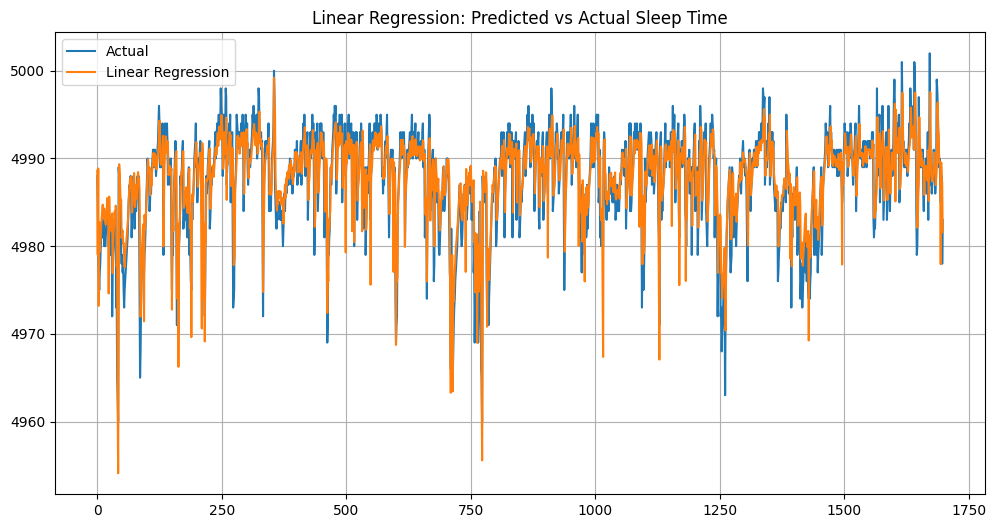

XGBoost → RMSE: 2.61, MAE: 1.74, R2: 0.7981


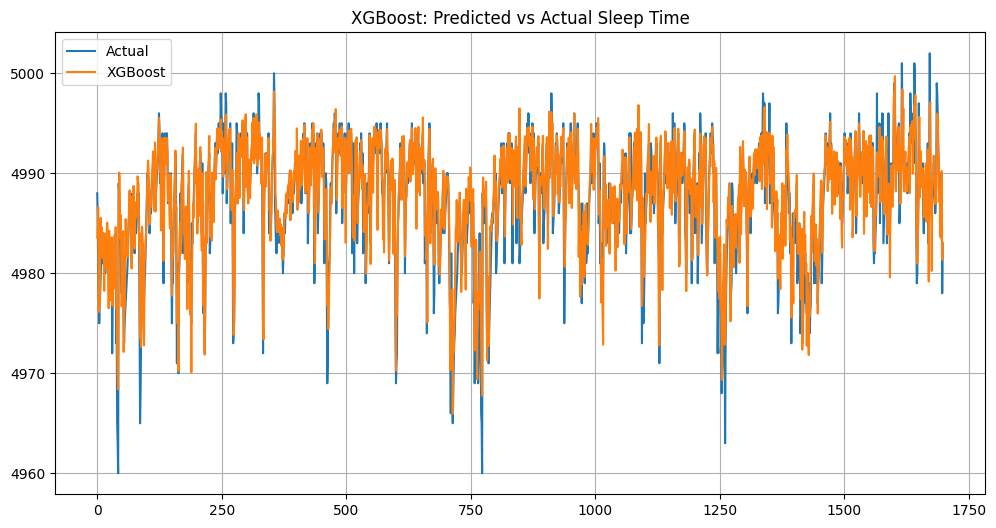

In [6]:
logs = read_all_logs('../Dataset/rl_500_exps/rl_500_5')

train_devices = [f'dev {i}.txt' for i in range(1, 8)]
val_devices = ['dev 8.txt']
test_devices = ['dev 10.txt']

X_train, y_train = aggregate_data(logs, train_devices)
X_test, y_test = aggregate_data(logs, test_devices)
X_val, y_val = aggregate_data(logs, val_devices)

linearReg = train_and_evaluate_linear(X_train, y_train, X_test, y_test)
xgBoost = train_and_evaluate_xgb(X_train, y_train, X_test, y_test)